# FIFA Transfer Market Analysis of European Football Leagues
## Data 512 Project
## Tharun Sikhinam

## I. Introduction

Transfer windows are as busy a time as any other in the football world. The game attracts so much attention that even when the ball is not rolling, the eyes of the entire world are on football. Transfers occur all year round and in every corner of the globe, but activity on the transfer market is typically at its peak during the summer and winter season.

The purpose of this project is to study of the economics in play from 1990 - 2019 in the transfer market of the top european leagues. It would be interesting to know how the trends have changed over the years. And by looking closely at the data, one hopes to uncover any hidden trends and explain the rise of the elite clubs in the European continent. With each clubs bringing in vast amounts of money through TV rights and other sources, it would be interesting to know how the clubs have put this money to use.

Understanding these macroeconomics can help us build a fair game and find areas of improvement. Through this analysis we want to address the wealth inequality of the top elite european clubs and how football has almost become a ‘money-game’. 


## II. Background

The best resource for transfmer markets is the official FIFA TMS[1]. This link holds a summary reports for each transfer window in the european leagues dating back to 2013. The analysis concentrates on a particular transfer window and not the trends over the years. While the report talks about how each country is represented, the players are not classified on their Position (Striker, Midfield etc.,) Through this analysis we wish to answer questions such as "Which country produces the best strikers?"

KPMG also publishes reports on clubs valuations and their spendings[2]. These reports also serve as useful guidelines so that I don't replicate any existing work. Most of these papers focus on a short duration of time, and this motivated me to explore the trends dating back to 1990 and correlating some of the trends found to real-life events.

The wealth gap between the top clubs and lower level clubs has been evident for a while [3], but it would be intersting to know what the exact numbers are. And how this wealth gap has been changing over the years. This can inform football policy makers to design better laws to safeguard the values and spirit of the game.

## III. Data

The data for this analysis is scraped off of transfermarkt.co.uk
The scraping was done in accordance with the Terms of Use in this link: https://www.transfermarkt.co.uk/intern/anb After reading the Terms of Use, it clearly states that

```4.8. With the transmission of Content, Transfermarkt grants you the irrevocable, temporally and spatially unlimited and transferable right to reproduce, distribute, publish, issue, make publicly accessible, modify, translate and store the Content. This includes the right to edit, design, adapt to the file formats required for use, and to change and / or improve the presentation quality.```

Furthermore looking at the https://www.transfermarkt.co.uk/robots.txt , the pages we want to scrap off of are not disallowed and are open to web crawlers and scrapers.

This dataset consists of all transfers in the European football market from 1991-2018. The data consists of a player name, club-out, club-in along with the transfer value grouped by different leagues. The dataset also consists of free transfers and loans as well. Most of the data is updated and contributed by the users of the website, and there might be few factual inaccuracies in the transfer figures stated.

<b>Ethical considerations:</b> Player names and ages have been removed from the dataset and will not be used as part of the analysis. This analysis doesn't aim to disrespect any player or country. The results of the analysis are aimed at the governing bodies of different leagues and sport lawmakers. Individual clubs are singled out over the analysis.

## IV. Research Questions

The following research questions are posed and answered methodically following best practices:

- <b>Q1. How has the transfer spending increased in the top 5 European Leagues?</b>
- <b>Q2. Which clubs spent the most and received the most transfer fee on players from 2010-2018?</b>
- <b> Q3. How have transfers fees moved betwen the leagues from 2010-2018? </b>
- <b> Q4. How has the wealth gap changed amongst the European elite? </b>
- <b> Q5. Investigating the spending trends of Manchester City, Chelsea and Paris Saint-Germain </b>
- <b> Q6. Which country produces the best footballing talent? </b>


## V. Reproducibility

Each individual section of the analysis can be reproduced in its entirety. To reproduce the analysis, the following softwares have to be installed
- R
- python
- pandas
- numpy
- matplotlib
- sqlite3
- javascript/codepen
- Tableau

For questions 1-5 of the analysis sqlite3 is used as a database to query the results from. Sqlite3 is an in-memory/local database that is easy to setup and use. An installation of sqlite3 is recommended to reproduce all parts of the analysis.  https://www.sqlite.org/download.html  
Javascript is used to create a sankey diagram for research question 3. The code for the javascript visualization can be found at https://codepen.io/tharunsikhinam/pen/QWwbzKj.  
To create annotations and vertical stacked bar chart for question 5, Tableau was used. The Tableau .twb file is stored in the root directory of the project called q5Viz.twb. Load the file into tableau desktop/online to view the visualization.  
A copy of the database used for the analysis is also stored in the cleanData table, called as transfers.db. It holds all the tables necessary for the analysis and can be directly imported into sqlite3 or any other SQL database.


## VI. Analysis and Code

The analysis and code section of this document is broken down into 3 main parts
1. Data Collection
2. Data Pre-Processing
3. Data Analysis & Results

## 1. Data Collection


#### Data is scraped off of transfermarket.co.uk in accordance with their Terms of Use. 
#### The R scripts to scrape data are stored under scrapingScripts/, run the following cell to generate raw data
``` R < scriptName.R --no-save  ```

### 1.1 Run R scripts to scrape data

In [11]:
!R < ./scrapingScripts/01-scrape.R --no-save


R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-apple-darwin15.6.0 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> 
> # setup -------------------------------------------------------------------
> getwd()
[1] "/Users/tharun/workspace/data-512/data-512-project"
> # load packages / local functions
> source("./scrapingScripts/00-setup.R")
Loading required package: pacman
> 
> # seasons to scrape
> seasons <- c(201

#### scrape.R can be modified to include more seasons and leagues, by default we are considering the years 1991-2018 and the European leagues from England, Spain, Italy, France, Germany, (Top 5) , Portugal and Netherlands

### 1.2 List first 5 files in data directory

In [362]:
from os import walk
f = []
for (dirpath, dirnames, filenames) in walk("./rawData"):
    f.extend(filenames)
    break
f[0:5]

['spanish_primera_division_2018.csv',
 'english_championship_1991.csv',
 'italian_serie_a_2000.csv',
 'italian_serie_a_2014.csv',
 'german_bundesliga_1_2018.csv']

### 1.3 Combining data into one file

In [305]:
import pandas as pd
import glob

interesting_files = glob.glob("./rawData/*.csv") 

# Combine data frames inside rawData directory
combinedDf = pd.concat((pd.read_csv(f, header = 0) for f in interesting_files))

In [306]:
combinedDf.to_csv("./cleanData/allSeasons.csv")
combinedDf.head(5)

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,nat,fee_cleaned,league_name,year,season
0,Athletic Bilbao,Yuri Berchiche,28.0,Left-Back,Paris SG,£21.60m,in,Spain;,21.60,Primera Division,2018,2018/2019
1,Athletic Bilbao,Ibai Gómez,29.0,Right Winger,Alavés,£3.60m,in,Spain;,3.60,Primera Division,2018,2018/2019
2,Athletic Bilbao,Ander Capa,26.0,Right-Back,SD Eibar,£2.70m,in,Spain;,2.70,Primera Division,2018,2018/2019
3,Athletic Bilbao,Cristian Ganea,26.0,Left-Back,FC Viitorul,£900k,in,Romania;Spain;,0.90,Primera Division,2018,2018/2019
4,Athletic Bilbao,Kenan Kodro,25.0,Centre-Forward,FC Copenhagen,£810k,in,Bosnia-Herzegovina;Spain;,0.81,Primera Division,2018,2018/2019


## 2. Data Pre-Processing

In [370]:
import pandas as pd
import numpy as np
raw = pd.read_csv("./cleanData/allSeasons.csv")

#### Shape of the dataset

In [364]:
raw.shape

(147027, 13)

#### Columns

In [371]:
raw.columns

Index(['Unnamed: 0', 'club_name', 'player_name', 'age', 'position',
       'club_involved_name', 'fee', 'transfer_movement', 'nat', 'fee_cleaned',
       'league_name', 'year', 'season'],
      dtype='object')

### 2.1 Dropping unnecessary columns

In [372]:
raw.head(5)
raw = raw.drop(["player_name","age","fee"],axis=1)

### 2.2 Clean up nationality and position
#### For players belonging to more than one nation, only the first country is used
#### Positions are generalized into Forwards, Midfield, Defense, Wingers and Goalkeepers


In [373]:
# Consider only the first country that player belongs to
def cleanCountry(row):
    if isinstance(row["nat"],str) :
        return row["nat"].split(";")[0]
    else:
        return row["nat"]
    
# Replace positions with a general category    
def cleanPosition(row):
    if isinstance(row["position"],str) :
        if "Midfield" in row["position"]:
            return "Midfield"
        elif row["position"].find("Back")>-1:
            return "Defense"
        elif "Forward" in row["position"]:
            return "Forward"
        elif "Striker" in row["position"]:
            return "Forward"    
        elif "Winger" in row["position"]:
            return "Winger"
        else:
            return row["position"]
    else:
        return row["position"]

<b>Clean up country  
Clean up position and add new posNew column  
Remove incoming transfers (duplicates)  
Remove rows from Championship, we're only considering top flight leagues  </b>

In [374]:
# Clean up country
raw["nat"] = raw.apply(cleanCountry,axis=1)
# Clean up Position aand add new posNew column
raw["posNew"] = raw.apply(cleanPosition,axis=1)
# Remove incoming transfers (duplicates)
raw = raw[raw['transfer_movement']=='in']
# Remove rows from Championship, we're only considering top flights leagues
raw = raw[raw["league_name"]!="Championship"]

### 2.4 Replace NA's with zero's and drop all rows with zero's

#### For the purposes of this analysis we will be only considering publicly stated transfers. Transfers involving loans, free transfers and end of contract signings are not considered.

In [375]:
# Replace 0's with NA's and drop rows  
raw = raw.replace(0,np.nan)
raw = raw.dropna()
leagues = raw.league_name.unique()

In [376]:
raw.to_csv("./cleanData/allSeasonsClean.csv")
raw.shape

(12583, 11)

### 2.5. Load data into SQLite

<b>For all future parts of this analysis a local installation of sqlite3 is recommended. Download sqlite3 from the following link and unzip the file https://www.sqlite.org/download.html. </b>

<b>
We will be using an in-memory database to run SQL queries against. If you would like to create a persistent copy of the database, replace :memory: with a path in the filesystem
</b>

In [377]:
import sqlite3
import pandas as pd

# Create a new database called transfers.db
raw = pd.read_csv("./cleanData/allSeasonsClean.csv")
cnx = sqlite3.connect(":memory:")

# create the dataframe from a query
raw.to_sql("transfer", cnx, if_exists='append', index=False)

/Users/tharun/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


#### Verifying counts in database

In [378]:
df = pd.read_sql_query("SELECT count(*) FROM transfer limit 1", cnx)
df.head()

,count(*)
0,12583


#### Loading inflation dataset

<b>British inflation data is obtained from http://inflation.iamkate.com/ under the CC0 1.0 Universal License https://creativecommons.org/publicdomain/zero/1.0/legalcode 
    
<b>Multiplier mentions by how much the price at a particular year should be multiplied by to get an inflation adjusted value</b>

In [379]:
inflation = pd.read_csv("./cleanData/inflation.csv")
inflation.head()

,Year,Multiplier
0,2018,1.00
1,2017,1.04
2,2016,1.05
3,2015,1.07
4,2014,1.09


In [380]:
inflation.to_sql("inflation", cnx, if_exists='append', index=False)

### 2.6. Adjust transfer fee for inflation

<b>Adjust transfer fees for inflation and store this data as transfers table</b>

In [381]:
inflation_adjusted = pd.read_sql_query("select transfer.*,(fee_cleaned*multiplier) as `fee_inflation_adjusted` from transfer join inflation on transfer.year = inflation.year",cnx)
inflation_adjusted.to_sql("transfers", cnx, if_exists='append', index=False)


## 3. Data Analysis

#### Verifying data in the table

In [382]:
pd.read_sql_query("SELECT count(*) FROM transfers limit 1", cnx).head()

,count(*)
0,12583


## Q1. How has the transfer spending increased in the top 5 European Leagues?

Transfer records are being broken every summer, with player values reaching upwards for £100M pounds. English Premier League in particular seems to be setting the trend for high transfer spending with some of the richest clubs belonging to England. Through this question we want to analyze how the transfer spending has increased amongst the top flights leagues in Europe.  
The actual inflation from 1990's to 2018's is over 2.5% for the British Pound[4], while the inflation in transfer spending appears to be extreme. We want to be able to quantify this increase in value of players.

To observe the trends over the years we write a SQL query that sums over the transfer_fee spending for each  league over the years.  
SQL query - sum(transfer_fee) and group by league_name and year


In [383]:
df = pd.read_sql_query("SELECT league_name,year,sum(fee_inflation_adjusted) as `total_spending in £million` from transfers where\
                       league_name in ('Serie A', '1 Bundesliga', 'Premier League', 'Ligue 1','Primera Division') \
                       group by league_name,year",cnx)
df.head(5)

,league_name,year,total_spending in £million
0,1 Bundesliga,1991,63.91224
1,1 Bundesliga,1992,53.74992
2,1 Bundesliga,1993,65.19518
3,1 Bundesliga,1994,93.10642
4,1 Bundesliga,1995,130.20399


### Plot

Text(0.5, 1.0, 'Transfer Spending in the top 5 European Leagues')

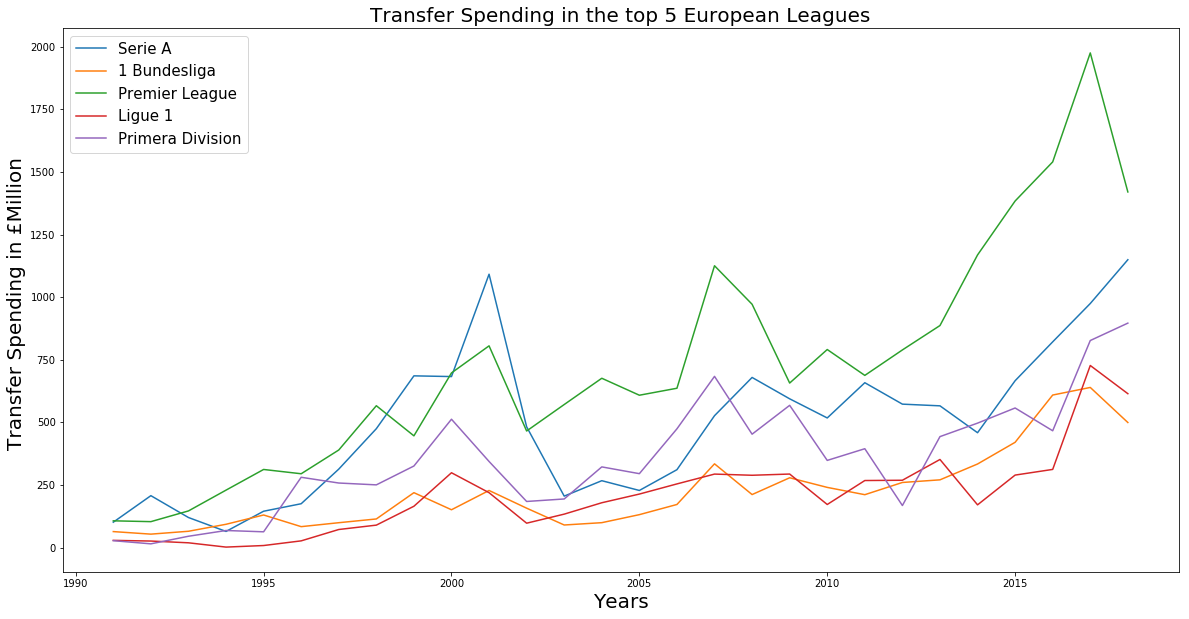

In [387]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
for l in ['Serie A', '1 Bundesliga', 'Premier League', 'Ligue 1','Primera Division']:
    x = df[df["league_name"]==l]
    plt.plot(x["year"], x["total_spending in £million"],label=l)
plt.legend(prop={'size': 15})
plt.xlabel("Years",fontsize = 20)
plt.ylabel("Transfer Spending in £Million ",fontsize = 20)
plt.title("Transfer Spending in the top 5 European Leagues",fontsize = 20)


### Results
- Transfer spending has been steadily increasing for all European leagues since 1991
- The spending gap between Premier League and the others  shows a steep increase since the 2010.
- The percentage change in median price of player from 1990’s to 2018 is 521%
- The rise TV rights revenue can be an explanation for the rise in Premier League Transfer Spending (https://www.usatoday.com/story/sports/soccer/2019/05/21/english-premier-league-broadcast-rights-rise-to-12-billion/39500789/) 

## Q 2.1. Which clubs spent the most on players from 2010-2018?

After observing the trends in transfer spending to increase by the year, it would be interesting to know who are the top spenders and which clubs receive the most in transfer fees. You would expect the top spenders to also produce the best footballing talent. The results from this question paint a different picture

### SQL Query - sum(transfer_fee) and group by club_name and order by descending

In [332]:
topSpenders = pd.read_sql_query("SELECT club_name,league_name,sum(fee_inflation_adjusted) as `total_spending in £million` from transfers where\
                       year>2010 and year<2019\
                       group by club_name,league_name order by `total_spending in £million` desc",cnx)
topSpenders = topSpenders.head(10)
topSpenders.head(10)

,club_name,league_name,total_spending in £million
0,Manchester City,Premier League,1091.67252
1,Chelsea FC,Premier League,1043.53560
2,Paris Saint-Germain,Ligue 1,999.81630
3,Manchester United,Premier League,957.71340
4,Juventus FC,Serie A,954.37664
5,FC Barcelona,Primera Division,931.91810
6,Liverpool FC,Premier League,877.93216
7,AS Roma,Serie A,682.37935
8,Real Madrid,Primera Division,673.22300
9,Atlético Madrid,Primera Division,617.01605


### Plot

Text(0.5, 1.0, 'Clubs with highest transfer fee spending (2010-2018)')

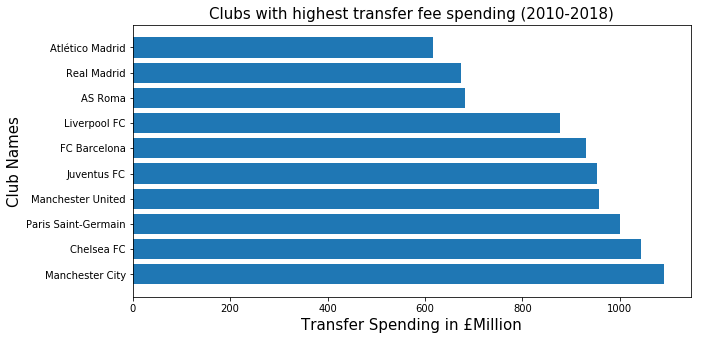

In [390]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(topSpenders["club_name"],topSpenders["total_spending in £million"])
plt.xlabel("Transfer Spending in £Million",fontsize = 15)
plt.ylabel("Club Names",fontsize = 15)
plt.title("Clubs with highest transfer fee spending (2010-2018)",fontsize = 15)


## Q 2.2: Which clubs receive the highest transfer fees for their players?

### SQL Query - sum(transfer_fee) over outgoing transfers and group by club_name and order by descending

In [334]:
highestReceivers = pd.read_sql_query("SELECT club_involved_name,sum(fee_inflation_adjusted) as `total_spending in £million` from transfers where\
                       year>=2010 and year<=2019\
                       group by club_involved_name order by `total_spending in £million` desc",cnx).head(10)
highestReceivers = highestReceivers.head(10)
highestReceivers.head(10)

,club_involved_name,total_spending in £million
0,Monaco,820.47040
1,Liverpool,623.73035
2,Benfica,592.63320
3,AS Roma,575.96250
4,Chelsea,562.63528
5,Juventus,536.67727
6,Real Madrid,501.64515
7,Bor. Dortmund,500.77116
8,FC Barcelona,467.06210
9,Spurs,460.68439


### Plot

Text(0.5, 1.0, 'Clubs receiving the highest transfer fee (2010-2018)')

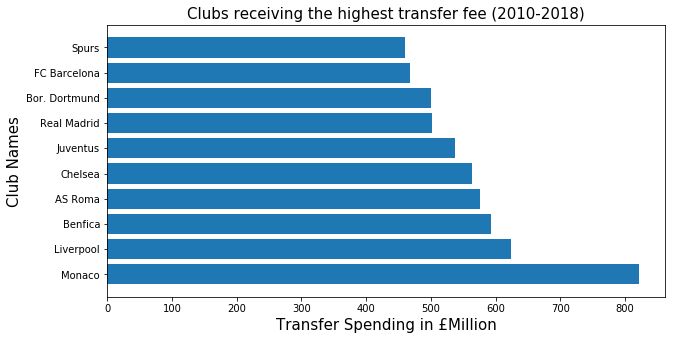

In [391]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(highestReceivers["club_involved_name"],highestReceivers["total_spending in £million"])
plt.xlabel("Transfer Spending in £Million",fontsize = 15)
plt.ylabel("Club Names",fontsize = 15)
plt.title("Clubs receiving the highest transfer fee (2010-2018)",fontsize = 15)

### Results

- The highest spending clubs are Manchester City, Chelsea and PSG. It would be interesting to know how the transfer trends have changed for these three clubs (explored in q5)
- The club with highest transfer fees received is Monaco a relatively small club from Ligue 1 (France). We also notice Benfica another club from Liga Nos (Portugal) that receives high transfer fees. This goes to show that the club spending the highest doesn't necessarily sell their players for a high value
- 4 of the top 10 highest spending clubs are from the English Premier League, which leads us into the next question. 

## Q3. How have the transfers flowed betwen the leagues from 2010-2018?

### We create a new temporary table 'movements' with the following columns: from_league, fee_spent and to_league

In [336]:
### To find out the movement of money across the leagues, we create a temporary table
df = pd.read_sql_query("select t1.league_name as 'to_league',fee_inflation_adjusted,b.league_name as 'from_league' from transfers t1 left outer join (select club_name,league_name from transfers \
                        where league_name!='Championship' and year>=2010 \
                        group by club_name,league_name) as b on t1.club_involved_name = b.club_name where t1.year>=2010",cnx);

df.to_sql("movements", cnx, if_exists='append', index=False)



In [342]:
movements = pd.read_sql_query("select to_league,sum(fee_inflation_adjusted) as fee_spent,from_league from movements where \
                                from_league is not null and to_league!=from_league group by to_league,from_league",cnx)
movements.head(5)

,to_league,fee_spent,from_league
0,1 Bundesliga,63.0353,Eredivisie
1,1 Bundesliga,4.2588,Liga Nos
2,1 Bundesliga,78.6060,Ligue 1
3,1 Bundesliga,7.9515,Premier League
4,1 Bundesliga,190.0360,Primera Division


### The above data is loaded into a sankey diagram written in javascript, the visualization is displayed below (only visible when using notebook). 
### Code for the visualization can be found at https://codepen.io/tharunsikhinam/pen/QWwbzKj
### Link to the visualization https://codepen.io/tharunsikhinam/full/QWwbzKj

In [111]:
# Display the associated webpage in a new window
import IPython
url = 'https://codepen.io/tharunsikhinam/full/QWwbzKj'
iframe = '<iframe src=' + url + ' width=1000 height=700></iframe>'
IPython.display.HTML(iframe)

### Results
- The league importing the maximum talent is the English Premier League. This also explains the high transfer spending in that league.
- The league exporting most talent is La Liga (Spain). The Spanish League exports players to nearly all leagues with the highest being to English Premier League. 

## Q 4: How has the wealth gap changed amongst the European elite?

### For this part of the analysis we will be only focussing on the top 5 European leagues

In [393]:
leagues = ['Primera Division', 'Serie A', '1 Bundesliga', 'Premier League','Ligue 1']

### To evaluate the wealth gap
 - We collect top 5 spenders in each league and calculate their transfer spending over the years
 - We collect the bottom 15 in the league and calculate their transfer spendings over the years
 - The above two measures are plotted on a graph

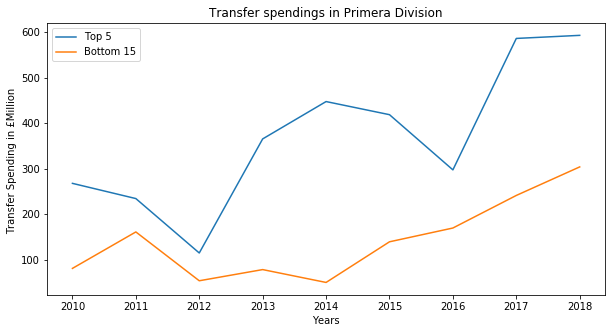

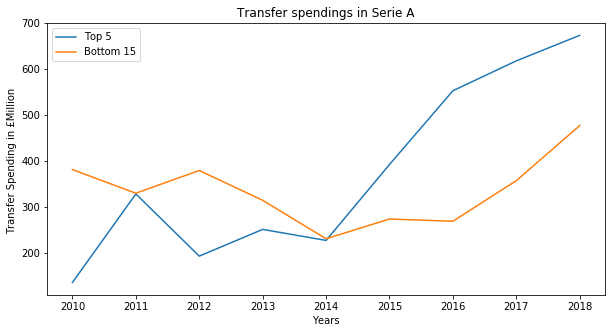

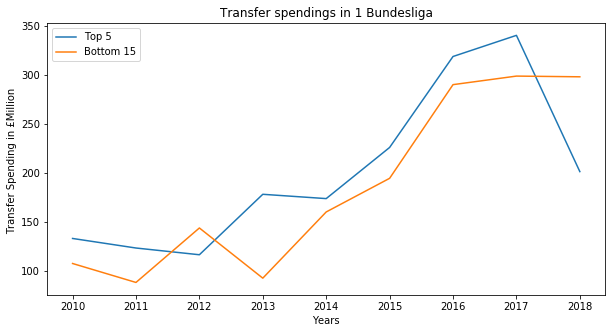

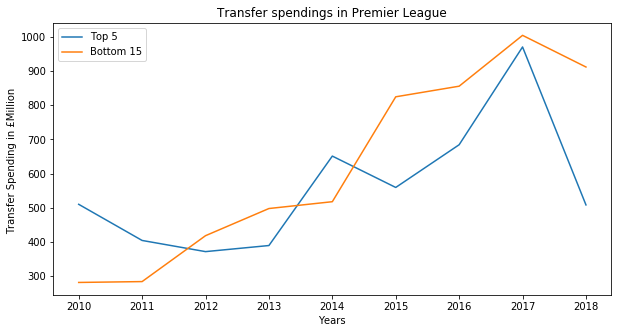

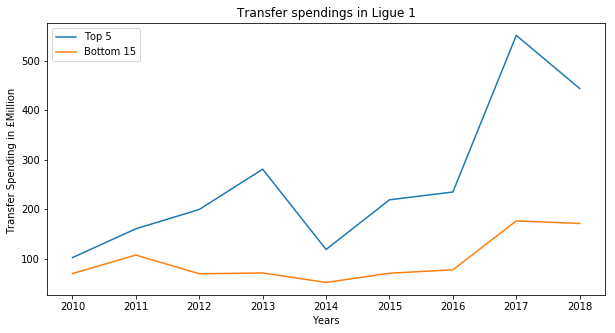

In [394]:
i=120;
for l in leagues:
    plt.figure()
    # Query to get spendings of top 5 clubs in a league
    df = pd.read_sql_query("select '"+l+"' ,year,sum(fee_inflation_adjusted) from transfers where club_name in\
(select club_name from transfers where league_name='"+l+"'\
and year>=2010 \
group by club_name order by sum(fee_cleaned) desc limit 5) and league_name='"+l+"'\
and year>=2010 group by year",cnx)
    plt.plot(df["year"], df["sum(fee_inflation_adjusted)"],label="Top 5")
    
    # Query to get spendings of bottom 15 clubs in a league
    df = pd.read_sql_query("select '"+l+"' ,year,sum(fee_inflation_adjusted) from transfers where club_name not in\
(select club_name from transfers where league_name='"+l+"'\
and year>=2010 \
group by club_name order by sum(fee_cleaned) desc limit 5) and league_name='"+l+"'\
and year>=2010 group by year",cnx)
    plt.title("Transfer spendings in " + l )
    plt.plot(df["year"], df["sum(fee_inflation_adjusted)"],label="Bottom 15")
    plt.xlabel("Years",fontsize = 10)
    plt.ylabel("Transfer Spending in £Million ",fontsize = 10)
    plt.legend()
  

### Results
- We observe a huge wealth inequality between the top and bottom clubs in Ligue 1, Serie A and Primera Division
- The difference is not so significant for English Premier League and the Bundesliga
- This is still a cause for concern since the top 5 clubs hold a disproportionate share of wealth in the top flight clubs
- These top 5 clubs in their respective leagues have won the domestic or international titles since 2010 (except for Leicester City in 2016).
- High transfer spending for domestic and international performance can lead to inequality between leagues and clubs. 

## Q5: Investigating the spending trends of Manchester City, Chelsea and Paris Saint-Germain

We are particularly interested in the spending trends of the above 3 clubs. They have arrived into the footballing scene relatively recently and have gone on to challenge the European Elite.

#### Calculate transfer spendings over the years for the above clubs

In [285]:
df = pd.read_sql_query("select club_name,year,sum(fee_inflation_adjusted) as `transfer_fee_total` from transfers\
                    where club_name in ('Manchester City','Chelsea FC','Paris Saint-Germain') and year<=2017\
                    group by club_name,year",cnx)
df.head(5)

,club_name,year,transfer_fee_total
0,Chelsea FC,1991,7.52112
1,Chelsea FC,1992,5.37132
2,Chelsea FC,1993,6.82014
3,Chelsea FC,1994,10.70880
4,Chelsea FC,1995,3.23190


### For this question, Tableau was used to create the visualization. The Tableau file for the visualization can be found at clubsSpending.twb. 
Steps to reproduce the visualization
- Run the above SQL query 
- Dump the dataframe into csv file
- Open Tableau desktop/online. 
- Load the csv file into Tableau
- Move transfer_fee_total to rows
- Move year to columns
- Add club_name to color 
- Choose vertical stacked chart from the right top corner 

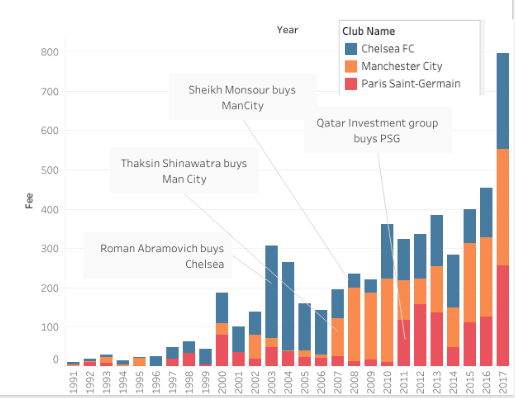

In [395]:
from IPython.display import Image
Image(filename='./images/q5.png') 

- Chelsea, Manchester City and PSG have challenged the European elite in the past decade partly due to their huge spending
- Chelsea’s investment grew by over 234%, while Paris Saint Germain’s by 477% and Manchester City’s by 621% 
- The huge transfer spendings can be attributed to the massive amounts of foreign investment into clubs

<b>Amount & time to first title</b>
- Chelsea - £470.5 million (2 yrs)
- Manchester City - £761 million (5 yrs)
- Paris SaintGermain - £421 million  (2 ys)

## Q 6: Which country produces the best footballing talent?

### Following steps are performed to decide which country produces the best kind of footballing talent
- Iterate over the years 2000-2018
- Iterate over chosen positions
- Sum transfer fee by nation 
- Rank countries in descending order of transfer spending
- Compute median rank over the years
- Sort by median rank and display for each position
- Disregard countries that appear in the top 10 rankings only 10 times in the 18 year span

In [355]:
clean  = raw
positions=['Forward', 'Midfield', 'Winger', 'Defense',
       'Goalkeeper']

final = {}
#Iterate over the years
for i in range(2000,2019):
    # Iterate over positions
    for pos in positions:
        if pos not in final:
            final[pos]=pd.DataFrame()
        # Sum over the fee by nation and rank 
        x = clean[(clean["posNew"]==pos)&(clean["year"]==i)].groupby(['nat'])['fee_cleaned'].agg('sum').rank(ascending=False).sort_values(ascending=True)
        x = x.to_frame()
        x["year"]=i
        final[pos]= final[pos].append(x)
# Add column to maintain counts
for pos in positions:
    final[pos]["count"]=1
    
# Compute median and display 
for pos in positions:
    z = final[pos].groupby('nat').median().reset_index()
    z1 = final[pos].groupby(['nat']).agg({"count":"count","fee_cleaned": "median",})
    print(pos)
    z1 = z1.rename(columns={"fee_cleaned": "median_rank","nat":"Country"})
    print(z1[z1["count"]>=10].drop(['count'],axis=1).sort_values(by="median_rank").head(5))
    print("\n\n")

Forward
           median_rank
nat                   
Argentina          3.0
Italy              3.0
Spain              4.0
France             5.0
Brazil             5.0



Midfield
         median_rank
nat                 
Brazil           2.0
France           3.0
Spain            4.0
England          4.0
Italy            4.0



Winger
             median_rank
nat                     
France               3.0
Spain                4.0
Netherlands          5.0
Portugal             5.5
England              6.5



Defense
         median_rank
nat                 
Italy            2.0
Brazil           3.0
France           3.0
England          3.0
Spain            5.0



Goalkeeper
         median_rank
nat                 
Italy            3.0
England          3.5
Brazil           5.0
Spain            5.0
Germany          6.0





## VII. Limitations
- All of the data is collected and maintained by users of the transfermarkt.co.uk website. There might be inaccuracies in the stated transfer figures. 
- These inaccuracies might be more frequent as we go back the years (1990-2000)
- As part of the analysis players on loan and free transfers are not being considered, this could change the results of the analysis
- Calculation of median rank might not be the best metric for measuring which country produces the best footballing talent. Player ratings or yearly performances are a better measure for this analysis


## VIII. Conclusion

- By analyzing the transfer market we are now aware of some of the big spenders in the European leagues and the hyper-inflation in transfer fees in the English Premier League

- With clubs raking in huge amounts of revenue, checks and balances need to be put into place to prevent the sport from being dominated from a few European elite clubs. which could lead to an European Super League

- High transfer spending for domestic and international performance can lead to wealth inequality between leagues and clubs. 

- The increase in foreign investments into European Clubs has led to the rise of super-rich clubs

- Clubs chasing success are spending more and more on players, which creates an unequal playing field for all the clubs. Although, it might not be feasible to completely curb the spending of these clubs, regulations need to be put in place to prevent such clubs from taking over.


## IX. References
1. FIFA TMS reports https://www.fifatms.com/data-reports/reports/
2. Evaluation football clubs in Europe - A report by KPMG https://www.footballbenchmark.com/library/football_clubs_valuation_the_european_elite_2019
3. Wealth gap in the top European Clubs https://www.usatoday.com/story/sports/soccer/2018/01/16/uefa-warns-of-growing-wealth-gap-in-top-clubs-finance-study/109521284/
4. British Inflation Calculator http://inflation.iamkate.com/